In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import lr_scheduler
from scipy import sparse
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import io, tarfile, os
import copy
from torch.nn.functional import binary_cross_entropy_with_logits as BCEwLogits
from GATModel import GraphAttentionNetwork
if torch.cuda.is_available():
    torch.cuda.current_device()
%env CUDA_LAUNCH_BLOCKING=1

datafile = "../../data/swde_HTMLgraphs_newtags.tar"

plt.ion()

SEED = 0

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

set_seed(SEED)

env: CUDA_LAUNCH_BLOCKING=1


***BELOW***
If data-loading < 5-10 % of total epoch time with num_workers=0, stick with the simple path.
Otherwise, parallel loading with share-friendly torch_sparse.SparseTensor
almost always pays off.

In [27]:
# ───────────────────────────────────────────────────────── Tar-reader dataset
class TarGraphDataset(Dataset):
    """
    Each graph is stored under its own sub-directory *inside* one .tar:

        graphs.tar
        ├── 0001/X.npz
        ├── 0001/E.npz
        ├── 0001/edge_index.npy
        ├── 0001/labels.npz
        ├── 0001/label_index.npy
        ├── 0001/label_value.npy
        ├── 0002/…
        └── …

    The tar is opened once; __getitem__ streams the six files for graph *idx*
    straight into memory, converts them to native PyTorch tensors and returns.
    """

    def __init__(self, tar_path: str | Path):
        self.tar = tarfile.open(tar_path, mode="r:*")      # gzip/none/…
        self.index: dict[str, dict[str, tarfile.TarInfo]] = {}
        self.sublen = {}

        # Build a small lookup table in RAM  {gid: {filename: tarinfo}}
        for member in self.tar.getmembers():
            if not member.isfile():
                continue

            p     = Path(member.name)
            gid   = str(p.parent)   # '0007'
            fname = p.name          # 'X.npz'

            # keep only folders that really are 4-digit graph IDs
            if gid[-4:].isdigit():
                self.index.setdefault(gid, {})[fname] = member

        self.gids = sorted(self.index)

        # Remove thos with no labels
        for gid, files in self.index.items():
            if not files.get("labels.npz"):
                self.gids.remove(gid)

        # Count
        name, counts = np.unique([Path(gid).parent.name for gid in self.gids], return_counts=True)

        # Get cumsum
        running = 0
        for lbl, cnt in zip(name, counts):
            self.sublen[lbl] = (running, running + cnt)
            running += cnt

    # ------------- helpers --------------------------------------------------
    @staticmethod
    def _npz_to_csr(buf: bytes, dtype=torch.float32):
        csr = sparse.load_npz(io.BytesIO(buf)).tocsr()
        crow = torch.from_numpy(csr.indptr.astype(np.int64))
        col  = torch.from_numpy(csr.indices.astype(np.int64))
        val  = torch.from_numpy(csr.data).to(dtype)
        return torch.sparse_csr_tensor(
            crow, col, val, size=csr.shape, dtype=dtype, requires_grad=False
        )

    @staticmethod
    def _npy_to_tensor(buf: bytes, dtype):
        arr = np.load(io.BytesIO(buf), allow_pickle=False)
        return torch.from_numpy(arr).to(dtype)

    def get_sublen(self, name):
        return self.sublen[name]

    # ------------- Dataset API ---------------------------------------------
    def __len__(self):
        return len(self.gids)

    def __getitem__(self, idx):
        gid   = self.gids[idx]
        files = self.index[gid]

        get = lambda name: self.tar.extractfile(files[name]).read()
        
        fileinfo = gid

        X   = self._npz_to_csr(get("X.npz"),       dtype=torch.float32)
        Aef = self._npz_to_csr(get("E.npz"),       dtype=torch.float32)
        Lef = self._npz_to_csr(get("labels.npz"),  dtype=torch.float32)

        Aei = self._npy_to_tensor(get("edge_index.npy"),  dtype=torch.int64)
        Lei = self._npy_to_tensor(get("label_index.npy"), dtype=torch.int64)
        y   = self._npy_to_tensor(get("label_value.npy"), dtype=torch.int64)
        titleIdx = self._npy_to_tensor(get("titleIdx.npy"), dtype=torch.int64)

        return fileinfo, X, Aei.t().contiguous(), Aef, Lei.t().contiguous(), Lef, y, titleIdx


In [28]:
def concat_csr(blocks):
    """
    Vertically stack CSR matrices that all share the same n_cols.
    Keeps sparsity and returns a single torch.sparse_csr_tensor.
    """
    crow_bufs, col_bufs, val_bufs = [], [], []
    nnz_so_far, n_rows, n_cols = 0, 0, blocks[0].size(1)

    for k, csr in enumerate(blocks):
        crow = csr.crow_indices().clone()          # (n_rows_k + 1,)

        # 1) shift by *cumulative* nnz so far
        crow += nnz_so_far

        # 2) drop the leading 0 for every block after the first
        if k > 0:
            crow = crow[1:]

        crow_bufs.append(crow)
        col_bufs.append(csr.col_indices())
        val_bufs.append(csr.values())

        nnz_so_far += csr.values().numel()
        n_rows     += csr.size(0)

    crow_cat = torch.cat(crow_bufs)
    col_cat  = torch.cat(col_bufs)
    val_cat  = torch.cat(val_bufs)

    return torch.sparse_csr_tensor(
        crow_cat, col_cat, val_cat,
        size=(n_rows, n_cols),
        dtype=val_cat.dtype,
        device=val_cat.device,
        requires_grad=False
    )


def sparse_graph_collate(batch):
    # unpack each graph
    filenames, xs, aei, aef, lei, lef, ys, titleIdxs = zip(*batch)

    # node-count prefix sum for shifting
    node_offsets = torch.cumsum(
        torch.tensor([0] + [x.size(0) for x in xs[:-1]]), 0)

    # ----- merge node features (CSR) -----------------------------
    X_batch = concat_csr(xs)

    # ----- merge structural edges --------------------------------
    Aei_shifted = []
    for off, ei in zip(node_offsets, aei):
        Aei_shifted.append(ei + off)   # shift both rows
    Aei_batch = torch.cat(Aei_shifted, dim=1)   # (2 , E_tot)

    Aef_batch = concat_csr(aef)

    # ----- merge label edges -------------------------------------
    Lei_shifted = []
    for off, ei in zip(node_offsets, lei):
        Lei_shifted.append(ei + off)
    Lei_batch = torch.cat(Lei_shifted, dim=1)

    Lef_batch = concat_csr(lef)
    y_batch   = torch.cat(ys)

    node_sizes = [x.size(0) for x in xs]
    node_ptr = torch.zeros(len(node_sizes) + 1, dtype=torch.long)
    node_ptr[1:] = torch.tensor(node_sizes, dtype=torch.long).cumsum(0)
    title_idx_local = torch.tensor(titleIdxs, dtype=torch.long)

    return filenames, X_batch, Aei_batch, Aef_batch, Lei_batch, Lef_batch, y_batch, node_ptr, title_idx_local

def debug_collate(batch):
    _, xs, aei, aef, lei, lef, ys = zip(*batch)
    print("--- one mini-batch ---")
    for i, X in enumerate(xs):
        print(f"graph {i}:  nodes={X.size(0):4d}   "
              f"struct-edges={aei[i].shape[1]:4d}   "
              f"label-edges={lei[i].shape[1]:3d}")
    # then call the real collate to keep training code unchanged
    return sparse_graph_collate(batch)

# ───────────────────────────────────────────────────────── loader utilities
def identity_collate(batch):
    """batch == list of length 1 → return that single sample untouched."""
    return batch[0]

def make_loader(ds, batch_size=1, shuffle=False):
    return DataLoader(ds,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      collate_fn=sparse_graph_collate,
                      num_workers=0,
                      pin_memory=True)    # fast GPU transfer

In [29]:
def plot_metrics_live(
    train_vals,
    val_vals,
    p, r, f1,                 # new metric lists (same length as train/val)
    save_path,
    xlabel="Epoch",
    ylabel_left="Loss / Accuracy",
    ylabel_right="P · R · F1",
    title="Training progress",
    fig_ax=None
):
    """
    Live-updating dual-axis plot.
    Call once per epoch with the (growing) metric lists.

    Parameters
    ----------
    train_vals, val_vals : list[float]
        Main metric to compare (e.g. loss or accuracy).
    p, r, f1 : list[float]
        Precision, recall, f1 – plotted on a secondary y-axis.
    save_path : str or Path
        Where to write the PNG each time.
    fig_ax : tuple(fig, (ax_left, ax_right)) | None
        Pass back what you got from the previous call to avoid flicker.

    Returns
    -------
    (fig, (ax_left, ax_right))
        Feed this straight back into the next call.
    """
    # ---------- figure / axes boilerplate ----------
    if fig_ax is None:
        fig, ax_left = plt.subplots(figsize=(8, 5))
        ax_right = ax_left.twinx()
    else:
        fig, (ax_left, ax_right) = fig_ax

    # ---------- clear and redraw ----------
    ax_left.cla()
    ax_right.cla()

    epochs = range(1, len(train_vals) + 1)

    # left-axis curves
    ax_left.plot(epochs, train_vals, "-o", label="Train", markersize=4)
    ax_left.plot(epochs, val_vals,   "-s", label="Val",   markersize=4)
    ax_left.set_xlabel(xlabel)
    ax_left.set_ylabel(ylabel_left)
    ax_left.grid(True, axis="both")

    # right-axis curves
    ax_right.plot(epochs, p,  "--d", label="Precision", markersize=4)
    ax_right.plot(epochs, r,  "--^", label="Recall",    markersize=4)
    ax_right.plot(epochs, f1, "--*", label="F1",        markersize=4)
    ax_right.set_ylabel(ylabel_right)

    # one combined legend
    lines_l, labels_l = ax_left.get_legend_handles_labels()
    lines_r, labels_r = ax_right.get_legend_handles_labels()
    ax_left.legend(lines_l + lines_r, labels_l + labels_r, loc="upper center", ncol=5)

    ax_left.set_title(title)
    fig.tight_layout()
    fig.savefig(Path(save_path), dpi=150)

    return fig, (ax_left, ax_right)

In [30]:
def per_graph_title_loss(title_logits: torch.Tensor,
                         node_ptr: torch.Tensor,
                         title_idx_local: torch.Tensor,
                         ignore_index: int = -1,
                         reduction: str = "mean") -> torch.Tensor:
    """
    title_logits:      (TotalN,) logits for ALL nodes in the batch (from your title head)
    node_ptr:          (G+1,) cumulative counts: [0, n0, n0+n1, ...]
    title_idx_local:   (G,)   per-graph LOCAL index 0..n_g-1 (or ignore_index for missing)
    """
    device = title_logits.device
    losses = []
    G = title_idx_local.numel()
    for g in range(G):
        t = title_idx_local[g].item()
        if t == ignore_index:   # allow graphs without title
            continue
        s, e = node_ptr[g].item(), node_ptr[g+1].item()
        lg = title_logits[s:e]                    # (n_g,)
        # CE expects (N, C). Treat as 1 sample with C=n_g classes:
        loss_g = F.cross_entropy(lg.unsqueeze(0),
                                 torch.tensor([t], device=device, dtype=torch.long))
        losses.append(loss_g)
    if not losses:
        # produce a 0 loss that still backprops cleanly
        return title_logits.sum() * 0.0
    return torch.stack(losses).mean() if reduction == "mean" else torch.stack(losses).sum()


def focal_loss(logits, targets, alpha = 0.25, gamma = 2.0, reduction: str = "mean"):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    p_t = torch.exp(-bce)          # = σ(z) if y==1 else 1-σ(z)
    loss = (alpha * (1.0 - p_t).pow(gamma) * bce)
    return loss.mean() if reduction == "mean" else loss.sum()


# ---------- 2. Pair-wise AUC (logistic ranking) loss -------------------------
def pairwise_auc_loss(logits, targets, sample_k: int | None = None):
    """
    logits   : float tensor (B,)
    targets  : {0,1} tensor (B,)
    sample_k : optional int – #negatives to sample per positive.  If None,
               uses *all* positives × negatives (can be heavy for big batches).
    """
    pos_logits = logits[targets == 1]      # shape (P,)
    neg_logits = logits[targets == 0]      # shape (N,)

    if pos_logits.numel() == 0 or neg_logits.numel() == 0:
        # No valid pairs (edge cases in small batches) – return 0 so it
        # doesn't break the graph.
        return logits.new_tensor(0.0, requires_grad=True)

    # --- optional negative subsampling to save memory ---
    if sample_k is not None and neg_logits.numel() > sample_k:
        idx = torch.randperm(neg_logits.numel(), device=logits.device)[:sample_k]
        neg_logits = neg_logits[idx]

    # Broadcast positives against negatives: diff = s_pos - s_neg
    diff = pos_logits[:, None] - neg_logits[None, :]        # (P, N) or (P, k)
    loss = F.softplus(-diff)                                # log(1+e^(-diff))

    return loss.mean()


# ---------- 3. Combined wrapper ----------------------------------------------
class PairwiseAUCFocalLoss(nn.Module):
    """
    total_loss = pairwise_auc_loss + lambda_focal * focal_loss
    """
    def __init__(self,
                 gamma: float = 2.0,
                 alpha: float = 0.25,
                 lambda_focal: float = 0.5,
                 sample_k: int | None = None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.lambda_focal = lambda_focal
        self.sample_k = sample_k

    def forward(self, logits, targets):
        loss_rank = pairwise_auc_loss(
            logits, targets, sample_k=self.sample_k
        )
        loss_focal = focal_loss(
            logits, targets, alpha=self.alpha, gamma=self.gamma
        )
        return loss_rank * (1 - self.lambda_focal) + self.lambda_focal * loss_focal


In [31]:
CLIP_NORM = 2.0           # gradient clipping

# ---------- one epoch --------------------------------------------------------
def train_epoch(model, loader, optimizer,
                criterion, sched, epoch, totalEpoch, device="cpu", **kwargs):

    model.train()
    
    running_loss, running_edges = 0.0, 0
    count = 0
    l = len(loader)

    for f, X_sparse, Aei, Aef, Lei, Lef, y, node_ptr, title_idx_local in loader:
        count += 1
        X_sparse, Aei, Aef = X_sparse.to(device), Aei.to(device), Aef.to(device)
        Lei, Lef, y = Lei.to(device), Lef.to(device), y.to(device)
        node_ptr, title_idx_local = node_ptr.to(device), title_idx_local.to(device)

        optimizer.zero_grad()
        
        edge_logits, title_logits = model(X_sparse, Aei, Aef, Lei, Lef, kwargs["p_Lef_drop"], kwargs["use_E_attr"], kwargs["use_A_attr"], return_title=True)          # (N_label,)

        edge_loss  = criterion(edge_logits, y.float())
        title_loss = per_graph_title_loss(title_logits, node_ptr, title_idx_local)
        loss = edge_loss + kwargs["lambda_title"] * title_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        sched.step()

        running_loss  += loss.item() * y.numel()
        running_edges += y.numel()

        if count % 20 == 0:
            print(f"epoch {count}/{l} "
                    f"loss={loss:.4f}")

    return running_loss / running_edges


# ---------- evaluation -------------------------------------------------------
@torch.no_grad()
def eval_edge_model(model, loader, criterion, device="cpu", thr_type="median", **kwargs):
    model.eval()
    TP = FP = FN = 0
    TP2 = FP2 = FN2 = 0
    running_loss, running_edges = 0.0, 0

    filenames = []
    for f, X_sparse, Aei, Aef, Lei, Lef, y, node_ptr, title_idx_local in loader:
        filenames += f
        X_sparse, Aei, Aef = X_sparse.to(device), Aei.to(device), Aef.to(device)
        Lei, Lef, y = Lei.to(device), Lef.to(device), y.to(device)
        node_ptr, title_idx_local = node_ptr.to(device), title_idx_local.to(device)

        #Complete Model
        edge_logits, title_logits = model(X_sparse, Aei, Aef, Lei, Lef, 0, kwargs["use_E_attr"], kwargs["use_A_attr"], return_title=True)
        edge_loss  = criterion(edge_logits, y.float())
        title_loss = per_graph_title_loss(title_logits, node_ptr, title_idx_local)
        loss = edge_loss + kwargs["lambda_title"] * title_loss
        running_loss  += loss.item() * y.numel()
        running_edges += y.numel()
        probs  = torch.sigmoid(edge_logits)
        if thr_type=="median":
            thr = torch.median(probs)

        pred = (probs >= thr).long()
        TP  += ((pred == 1) & (y == 1)).sum().item()
        FP  += ((pred == 1) & (y == 0)).sum().item()
        FN  += ((pred == 0) & (y == 1)).sum().item()

    print(f"Validating {np.unique([filename[:-5] for filename in filenames])} website type")
    
    prec = TP / (TP + FP + 1e-9)
    rec  = TP / (TP + FN + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    return running_loss / running_edges, prec, rec, f1

In [ ]:
def train_model(model,
                train_loader,
                val_loader,
                load_checkpoint,
                num_epochs     = 100,
                lr             = 1e-3,
                validate_every = 10,
                patience       = 10,
                device         = "cpu"):

    print(model)

    model_path = "./model_in_training.pt"
    if os.path.exists(model_path) and load_checkpoint:
        print("loading existing model...")
        model.load_state_dict(torch.load(model_path))

    model.to(device)
    
    opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = lr_scheduler.OneCycleLR(opt, max_lr=4e-4, epochs=num_epochs, steps_per_epoch=len(train_loader),
                   pct_start=0.1, anneal_strategy='cos', div_factor=25, final_div_factor=1e4, cycle_momentum=False)
                        #StepLR(opt, step_size=3, gamma=0.9)
    criterion = focal_loss
    lambda_title = 0.005
    # criterion = PairwiseAUCFocalLoss(
    #             gamma=2.0,
    #             alpha=0.25,
    #             lambda_focal=1,  # 0 ⇒ pure ranking loss; 1 ⇒ equal weight
    #             sample_k=128     # speeds up training; set None for exact loss
    #         )
    #criterion = nn.BCEWithLogitsLoss()

    best_f1, fig_ax, best_state = 0.0, None, None
    train_loss, val_loss, precision, recall, f1score = [], [], [], [], []

    for epoch in range(1, num_epochs + 1):
        p_Lef_drop = 0#.3 - 0.3 * (epoch-2)/(num_epochs-2 + 1e-9)        
        use_E_attr,  use_A_attr = (epoch>0), (epoch>0)

        loss = train_epoch(model, train_loader, opt, criterion, sched, epoch, num_epochs, device=device, use_E_attr=use_E_attr, use_A_attr = use_A_attr, p_Lef_drop = p_Lef_drop, lambda_title=lambda_title)
        train_loss.append(loss)

        if epoch % validate_every == 0 or epoch == num_epochs:
            loss, p, r, f1 = eval_edge_model(model, val_loader, criterion, device=device, use_E_attr=use_E_attr, use_A_attr = use_A_attr, lambda_title=lambda_title)
            val_loss.append(loss)

            lr_now = opt.param_groups[0]["lr"]
            print(f"Epoch {epoch:03d}/{num_epochs} "
                  f"loss={loss:.4f}  P={p:.3f} R={r:.3f} F1={f1:.3f}  lr={lr_now:.2e}  E_features={use_E_attr} A_features={use_A_attr}")
            precision.append(p)
            recall.append(r)
            f1score.append(f1)

            if f1 >= best_f1:
                best_f1, best_state = f1, copy.deepcopy(model.state_dict())

            # if lr_now < 1e-5:
            #     print("Stop: LR < 1e-5")
            #     break

            fig_ax = plot_metrics_live(
                train_loss,
                val_loss,
                precision,recall,f1score,
                "CurrentRun",
                xlabel="Epoch",
                ylabel_left="Loss",
                ylabel_right="P · R · F1",
                title="Model Performance",
                fig_ax=fig_ax
            )
            
            with torch.no_grad():
                torch.save(model.state_dict(), model_path)

    if best_state is not None:
        model.load_state_dict(best_state)

    return best_state, train_loss, val_loss, fig_ax


GraphAttentionNetwork(
  (tr1): TransformerConv(119, 32, heads=2)
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (tr2): TransformerConv(64, 32, heads=1)
  (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (tr3): TransformerConv(32, 8, heads=1)
  (edge_mlp): Sequential(
    (0): Linear(in_features=48, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (title_head): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 20/356 loss=0.0841
epoch 40/356 loss=0.0824
epoch 60/356 loss=0.0825
epoch 80/356 loss=0.0809
epoch 100/356 loss=0.0799
epoch 120/356 loss=0.0784
epoch 140/356 loss=0.0782
epoch 160/356 loss=0.0775
epoch 180/356 loss=0.0762
epoch 200/356 loss=0.0755
epoch 220/356 loss=0.0750
epoch 240/356 loss=0.0751
epoch 260/356 loss=0.0737
epoch 280/356 loss=0.0734

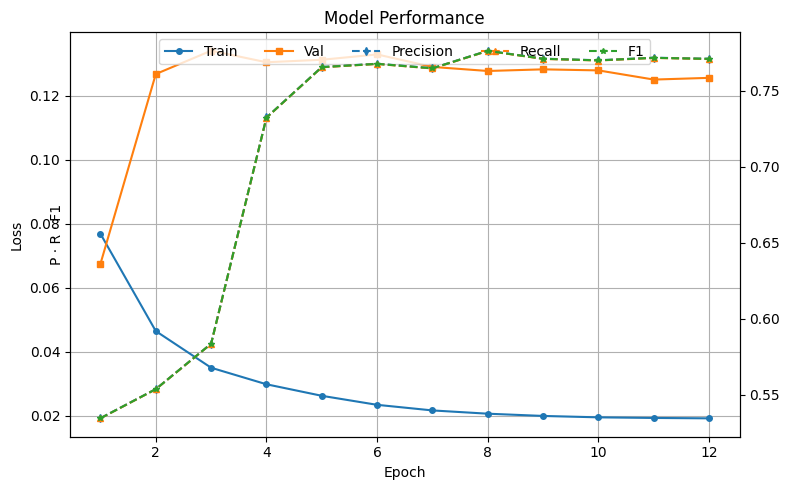

In [33]:
dataset = TarGraphDataset(datafile)
N = len(dataset)
# n_train = int(0.95 * N)
# n_val   = N - n_train
# train_ds, val_ds = random_split(dataset, [n_train, n_val])
matchcollege_start, matchcollege_end = dataset.get_sublen('university-matchcollege(2000)')
allmovie_start, allmovie_end = dataset.get_sublen('movie-allmovie(2000)')
imdb_start, imdb_end = dataset.get_sublen('movie-imdb(2000)')
usatoday_start, usatoday_end = dataset.get_sublen('nbaplayer-usatoday(436)')
yahoo_start, yahoo_end = dataset.get_sublen('nbaplayer-yahoo(438)')
matchcollege_idx = list(range(matchcollege_start, matchcollege_end))
allmovie_idx = list(range(allmovie_start, allmovie_end))
imdb_idx = list(range(imdb_start, imdb_end))
usatoday_idx=list(range(usatoday_start, usatoday_end))
yahoo_idx=list(range(yahoo_start, yahoo_end))

val_idx = list(set(allmovie_idx))#list(set(matchcollege_idx[-10:])) + list(set(allmovie_idx[-10:]))#
train_idx = list(set(range(N)) - set(val_idx) - set(usatoday_idx) - set(yahoo_idx))#list(set(matchcollege_idx + allmovie_idx) - set(val_idx))#
train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_loader = make_loader(train_ds, batch_size=64, shuffle=True)
val_loader = make_loader(val_ds, batch_size=64, shuffle=True)

model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)#16,32,4 was the winner

load_checkpoint = False
_, trainloss, valloss, fig_ax = train_model(model,
            train_loader,
            val_loader,
            load_checkpoint,
            num_epochs     = 12,
            lr             = 1e-3,
            validate_every = 1,
            patience       = 1,
            device         = "cuda")

In [9]:
#Save model
torch.save(model.state_dict(), "FULLTRAINEDALLDATAModelf1-83-newtagsnotitle.pt")

In [ ]:
# model_path = "./FULLTRAINEDALLDATAModelf1-74-learning.pt"
# if os.path.exists(model_path) and load_checkpoint:
#     print("loading existing model...")
#     model.load_state_dict(torch.load(model_path))



eval_edge_model(model, val_loader, focal_loss, device="cuda", use_E_attr=True, use_A_attr=True)
#b4 submitting to A100
#Experiemnt with the comparison loss
#Do self layers myself
#
#Graphs of also without edges

#32 32 layers
#Just train everything from the start

Validating ['swde_HTMLgraphs/movie/movie/movie-allmovie(2000)'] website type


(0.04156546794519418,
 0.7552735881680096,
 0.7551079869696979,
 0.7551907779904338)